<a href="https://colab.research.google.com/github/pawelszajwaj/Segregation/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pobranie z githuba plików audio

In [3]:
!git clone https://github.com/pawelszajwaj/Segregation.git

fatal: destination path 'Segregation' already exists and is not an empty directory.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [47]:
import tensorflow as tf
import os

In [6]:
!pip install tensorflow-io
import tensorflow_io as tfio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!mkdir AudioFiles
!mkdir AudioFiles/Good
!mkdir AudioFiles/Bad

In [48]:
!unzip '/content/Segregation/AudioFiles/Good/*.zip' -d '/content/AudioFiles/Good'
!unzip '/content/Segregation/AudioFiles/Bad/*.zip' -d '/content/AudioFiles/Bad'
if os.path.exists("/content/AudioFiles/Bad/13.1.21.wav"):
  os.remove("/content/AudioFiles/Bad/13.1.21.wav")

Archive:  /content/Segregation/AudioFiles/Good/3_seconds_good_6-10.zip
replace /content/AudioFiles/Good/10.1.21.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N

Archive:  /content/Segregation/AudioFiles/Good/3_seconds_good_1-5.zip

2 archives were successfully processed.
Archive:  /content/Segregation/AudioFiles/Bad/3_seconds_bad_11-15.zip
replace /content/AudioFiles/Bad/15.1.18.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N

Archive:  /content/Segregation/AudioFiles/Bad/3_seconds_bad_21-23.zip

Archive:  /content/Segregation/AudioFiles/Bad/3_seconds_bad_16-20.zip

3 archives were successfully processed.


In [49]:
audio_files = glob('/content/AudioFiles/*/*.wav')
audio_files_good = glob('/content/AudioFiles/Good/*.wav')
audio_files_bad = glob('/content/AudioFiles/Bad/*.wav')

In [8]:
def load_wav_16k_mono(filename):
  file_contents = tf.io.read_file(filename)
  wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
  wav = tf.squeeze(wav, axis=-1)
  sample_rate = tf.cast(sample_rate, dtype = tf.int64)
  wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
  return wav

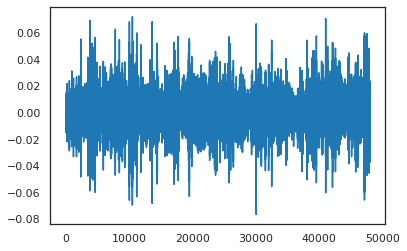

In [9]:
wav = load_wav_16k_mono(audio_files_bad[0])
wav = load_wav_16k_mono(audio_files_good[0])
plt.plot(wav.numpy())

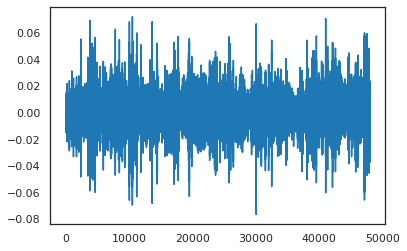

In [10]:
wav = tf.cast(wav, tf.float32)
plt.figure()
plt.plot(wav.numpy())

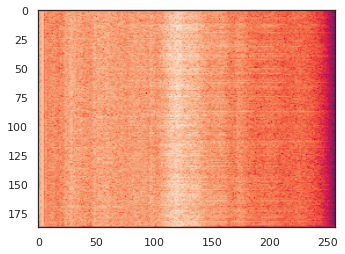

In [11]:
spectrogram = tfio.audio.spectrogram(
    wav, nfft=512, window=512, stride=256)
plt.figure()
plt.imshow(tf.math.log(spectrogram).numpy())

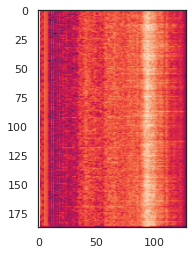

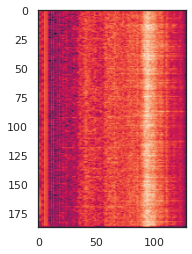

In [12]:
mel_spectrogram = tfio.audio.melscale(
  spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)
dbscale_mel_spectrogram = tfio.audio.dbscale(
  mel_spectrogram, top_db=80)

plt.figure()
plt.imshow(tf.math.log(mel_spectrogram).numpy())

plt.figure()
plt.imshow(dbscale_mel_spectrogram.numpy())

In [51]:
good = tf.data.Dataset.list_files('/content/AudioFiles/Good/*.wav')
bad = tf.data.Dataset.list_files('/content/AudioFiles/Bad/*.wav')
good.as_numpy_iterator().next()

b'/content/AudioFiles/Good/9.1.2.wav'

In [52]:
positives = tf.data.Dataset.zip((good, tf.data.Dataset.from_tensor_slices(tf.ones(len(good)))))
negatives = tf.data.Dataset.zip((bad, tf.data.Dataset.from_tensor_slices(tf.zeros(len(good)))))
data = positives.concatenate(negatives)
data.shuffle(1000).as_numpy_iterator().next()

(b'/content/AudioFiles/Bad/11.1.2.wav', 0.0)

In [53]:
def preprocess(file_path, label):
  wav = load_wav_16k_mono(file_path)
  wav = tf.cast(wav, tf.float32)
  spectrogram = tfio.audio.spectrogram(
    wav, nfft=512, window=512, stride=256)
  spectrogram = tf.abs(spectrogram)
  mel_spectrogram = tfio.audio.melscale(
    spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)
  dbscale_mel_spectrogram = tfio.audio.dbscale(
    mel_spectrogram, top_db=80)
  dbscale_mel_spectrogram = tf.expand_dims(dbscale_mel_spectrogram, axis=2)
  return dbscale_mel_spectrogram, label

In [54]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [55]:
print(len(data))
train = data.take(16)
test = data.skip(16).take(8)

26


In [56]:
samples, labels = train.as_numpy_iterator().next()

In [57]:
samples.shape

(16, 188, 128, 1)

In [58]:
labels

array([1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1.],
      dtype=float32)

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D

In [60]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(188, 128, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [61]:
model.compile("Adam", loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [62]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 186, 126, 16)      160       
                                                                 
 conv2d_8 (Conv2D)           (None, 184, 124, 16)      2320      
                                                                 
 flatten_3 (Flatten)         (None, 365056)            0         
                                                                 
 dense_6 (Dense)             (None, 128)               46727296  
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 46,729,905
Trainable params: 46,729,905
Non-trainable params: 0
_________________________________________________________________


In [63]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
16/16 [==============================] - 15s 838ms/step - loss: 229.2979 - recall_3: 0.5276 - precision_3: 0.5154 - val_loss: 31.5900 - val_recall_3: 1.0000 - val_precision_3: 0.6174
Epoch 2/4
16/16 [==============================] - 13s 815ms/step - loss: 9.5995 - recall_3: 0.6977 - precision_3: 0.6667 - val_loss: 2.9296 - val_recall_3: 0.4844 - val_precision_3: 1.0000
Epoch 3/4
16/16 [==============================] - 13s 816ms/step - loss: 0.7617 - recall_3: 0.9130 - precision_3: 0.8630 - val_loss: 0.1853 - val_recall_3: 0.9403 - val_precision_3: 0.9265
Epoch 4/4
16/16 [==============================] - 13s 790ms/step - loss: 0.1071 - recall_3: 0.9840 - precision_3: 0.9685 - val_loss: 0.0565 - val_recall_3: 0.9831 - val_precision_3: 1.0000


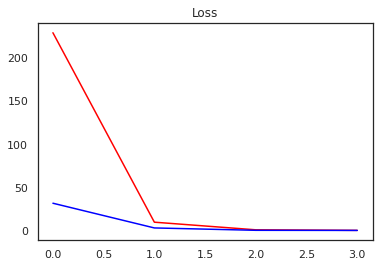

In [68]:
plt.title("Loss")
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'],'b')
plt.show()

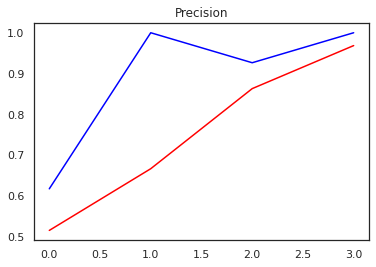

In [80]:
plt.title("Precision")
plt.plot(hist.history['precision_3'], 'r')
plt.plot(hist.history['val_precision_3'],'b')
plt.show()

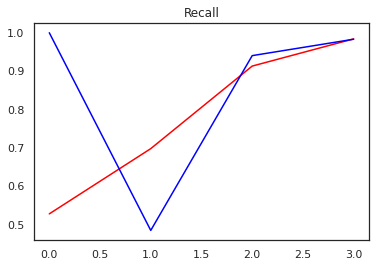

In [81]:
plt.title("Recall")
plt.plot(hist.history['recall_3'], 'r')
plt.plot(hist.history['val_recall_3'],'b')
plt.show()

In [70]:
# WIELKI TEST
X_test, y_test = test.as_numpy_iterator().next()

In [71]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 191ms/step


In [72]:
yhat

array([[9.9999118e-01],
       [6.4282656e-01],
       [3.1864646e-01],
       [1.0000000e+00],
       [3.6136713e-02],
       [9.9099708e-01],
       [2.0826591e-02],
       [1.5161663e-27],
       [3.8425577e-37],
       [1.0962215e-04],
       [9.1693312e-01],
       [9.9380177e-01],
       [1.0000000e+00],
       [7.2444507e-38],
       [7.1900403e-01],
       [9.2041715e-05]], dtype=float32)

In [73]:
y_test

array([1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0.],
      dtype=float32)

# **TO NIZEJ TO POZOSTALOSCI PO CZYMS INNYM, NA DOBRA SPRAWE TO CO WAZNE DZIEJE SIE WYZEJ**

In [ ]:
def plot_mel_spectrogram(filename):
  y, sr = librosa.load(filename)
  mel = librosa.feature.melspectrogram(y=y, 
                                    sr=sr,
                                    n_mels=128)
  mel_db = librosa.amplitude_to_db(np.abs(mel), ref = np.max)
  fig, ax = plt.subplots(figsize=(10,5))
  img = librosa.display.specshow(mel_db,
                             x_axis = 'time',
                             y_axis= 'log',
                             ax = ax)
  ax.set_title('Mel Spectrogram', fontsize=20)
  fig.colorbar(img, ax=ax, format=f'%0.2f')
  plt.show()

In [ ]:
ipd.Audio(audio_files_bad[0])

<AxesSubplot:title={'center':'Good one'}>

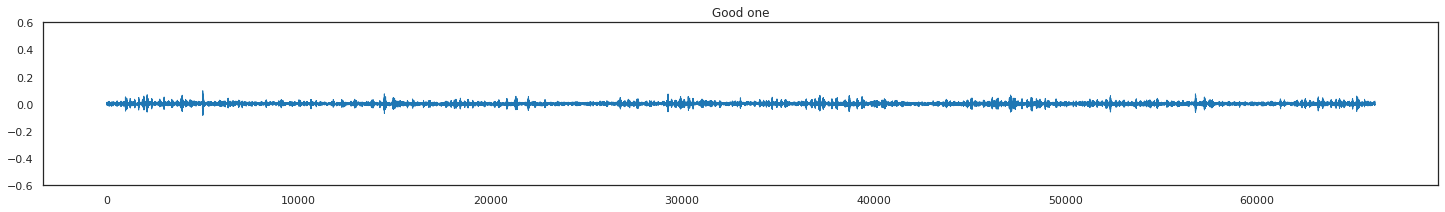

In [ ]:
y, sr = librosa.load(audio_files_good[0])
pd.Series(y).plot(figsize=(25, 3), lw = 1, title = "Good one", color = color_pal[0], ylim=[-0.6, 0.6])

<AxesSubplot:title={'center':'Bad one'}>

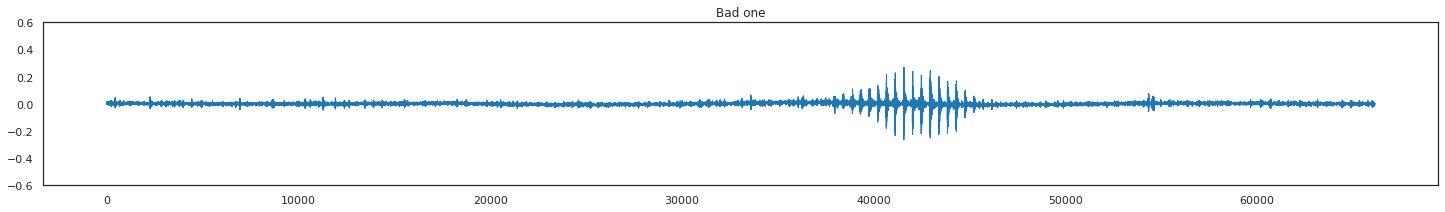

In [ ]:
y, sr = librosa.load(audio_files_bad[0])
pd.Series(y).plot(figsize=(25, 3), lw = 1, title = "Bad one", color = color_pal[0], ylim=[-0.6, 0.6])

In [ ]:
sample = librosa.stft(y)
sample_db = librosa.amplitude_to_db(np.abs(sample), ref = np.max)
sample_db.shape

(1025, 130)

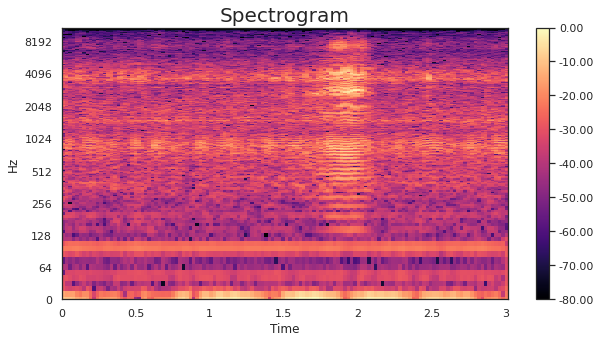

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(sample_db,
                             x_axis = 'time',
                             y_axis= 'log',
                             ax = ax)
ax.set_title('Spectrogram', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

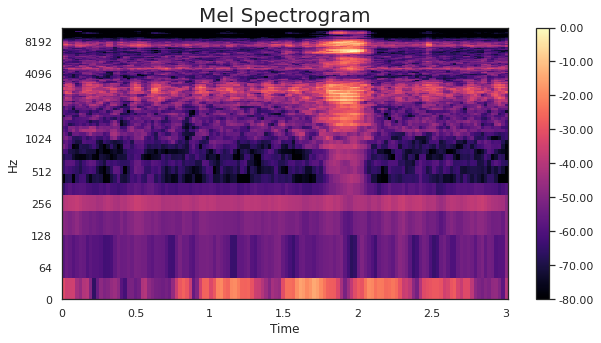

In [ ]:
plot_mel_spectrogram(audio_files_bad[0])

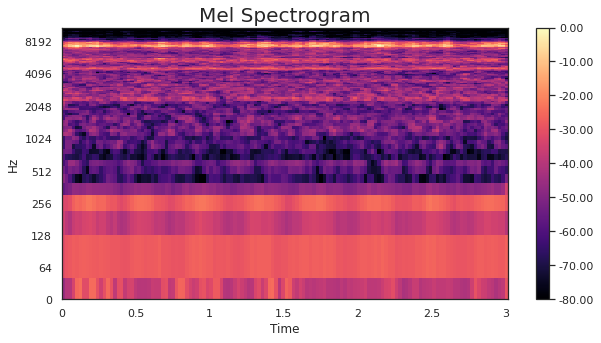

In [ ]:
plot_mel_spectrogram(audio_files_good[0])

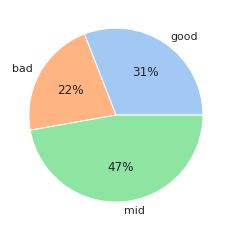

In [ ]:
data = [len(good_data), len(bad_data), len(mid_data)]
labels = ['good', 'bad', 'mid']

colors = sns.color_palette('pastel')[0:5]

plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [ ]:
def create_mel_spectrogram_data(y):
  mel = librosa.feature.melspectrogram(y=y, 
                                    sr=22050,
                                    n_mels=128)
  mel_db = librosa.amplitude_to_db(np.abs(mel), ref = np.max)
  return mel_db

In [ ]:
mel_good_data = []
mel_bad_data = []
mel_mid_data = []

for x in good_data:
  mel_good_data.append(create_mel_spectrogram_data(x))

for x in bad_data:
  mel_bad_data.append(create_mel_spectrogram_data(x))

for x in mid_data:
  mel_mid_data.append(create_mel_spectrogram_data(x))


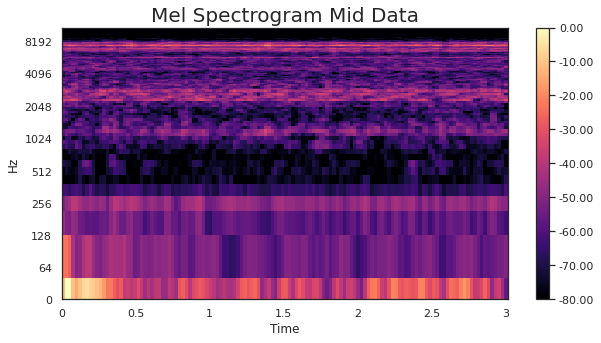

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(mel_mid_data[0],
                               x_axis = 'time',
                               y_axis= 'log',
                               ax = ax)
ax.set_title('Mel Spectrogram Mid Data', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

Tensorflow flow
To niżej na razie nie jest ważne kompletnie, choć w przyszłości raczej na pewnoe będzię istotne

In [ ]:
def load_wav(filename):
  file_contents = tf.io.read_file(filename)
  wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
  wav = tf.squeeze(wav, axis=-1)
  return wav

In [ ]:
wave = load_wav(audio_files_good[0])
nwave = load_wav(audio_files_bad[0])
mwave = load_wav(audio_files_mid[0])

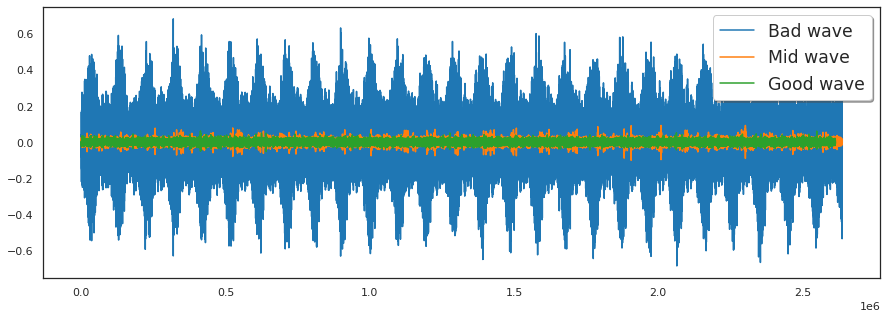

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(nwave, label='Bad wave')
ax.plot(mwave, label='Mid wave')
ax.plot(wave, label='Good wave')

legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')

plt.show()